# Modelando el comportamiento de los arriendos de bicicletas en Seúl según la temperatura ambiental. 


### Importando Librerias

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import statsmodels as sms
import statsmodels.formula as smf


### Importando y leyendo base de Datos SeoulBikeData

In [2]:
# Leer el dataset con datos imputados

bikedata = pd.read_excel("SeoulBikeData_DatosImputados.xlsx")

In [3]:
#Renombrando Variables para su evaluación y Proceso

bikedata=bikedata.rename({'Rented Bike Count': 'Rented_Bike_Count','Temperature(°C)': 'Temperature' ,'Humidity(%)':'Humidity', 'Wind speed (m/s)': 'wind_speed', 
                 'Visibility (10m)':'Visibility', 'Dew point temperature(°C)':'Dew_point_temperature', 
                 'Solar Radiation (MJ/m2)':'Solar_radiation', 'Rainfall(mm)':'Rainfall', 'Snowfall (cm)': 'Snowfall',
                 'Functioning Day': 'Functioning_Day' },axis=1)

### Cambiando Fecha a formato 'Datetime' y creando variables de día, mes, año para evaluación de los arriendos de bicicletas

In [4]:
#trasformar fecha a formato 'Datetime'

bikedata['Date']=pd.to_datetime(bikedata['Date'],infer_datetime_format= True)
bikedata['Month']=bikedata.Date.dt.month_name().str[:3]
bikedata['Year']= bikedata.Date.dt.year
bikedata['Weekday']= bikedata.Date.dt.weekday
bikedata.Weekday= bikedata.Weekday.map({0:'Monday', 1:'Tuesday',2:'Wednesday', 3:'Thursday', 4:'Fryday', 5: 'Saturday', 6:'Sunday'})
bikedata['Weekday']= pd.Categorical(bikedata['Weekday'],
                     categories= ['Monday','Tuesday','Wednesday','Thursday', 'Fryday','Saturday', 'Sunday'] , ordered=True)


In [5]:
#Evaluación de Esatdísticos de las variables

bikedata.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rented_Bike_Count,8760.0,736.804623,642.278158,2.0,218.00,556.0,1096.00,3556.0
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.5,17.25,23.0
Temperature,8760.0,117.488813,118.879484,-178.0,18.00,115.0,217.00,394.0
Humidity,8760.0,58.226256,20.362413,0.0,42.00,57.0,74.00,98.0
wind_speed,8760.0,15.646347,10.878694,0.0,7.00,14.0,23.00,74.0
Visibility,8760.0,1436.825799,608.298712,27.0,940.00,1698.0,2000.00,2000.0
Dew_point_temperature,8760.0,36.808333,124.048701,-306.0,-34.00,28.0,137.00,272.0
Solar_radiation,8760.0,52.008333,84.138884,0.0,0.00,1.0,78.00,352.0
Rainfall,8760.0,0.886872,7.859516,0.0,0.00,0.0,0.00,295.0
Snowfall,8760.0,0.609932,3.882392,0.0,0.00,0.0,0.00,88.0


### Correlacion de las variables del Dataset y el Arriendo de Bicicletas

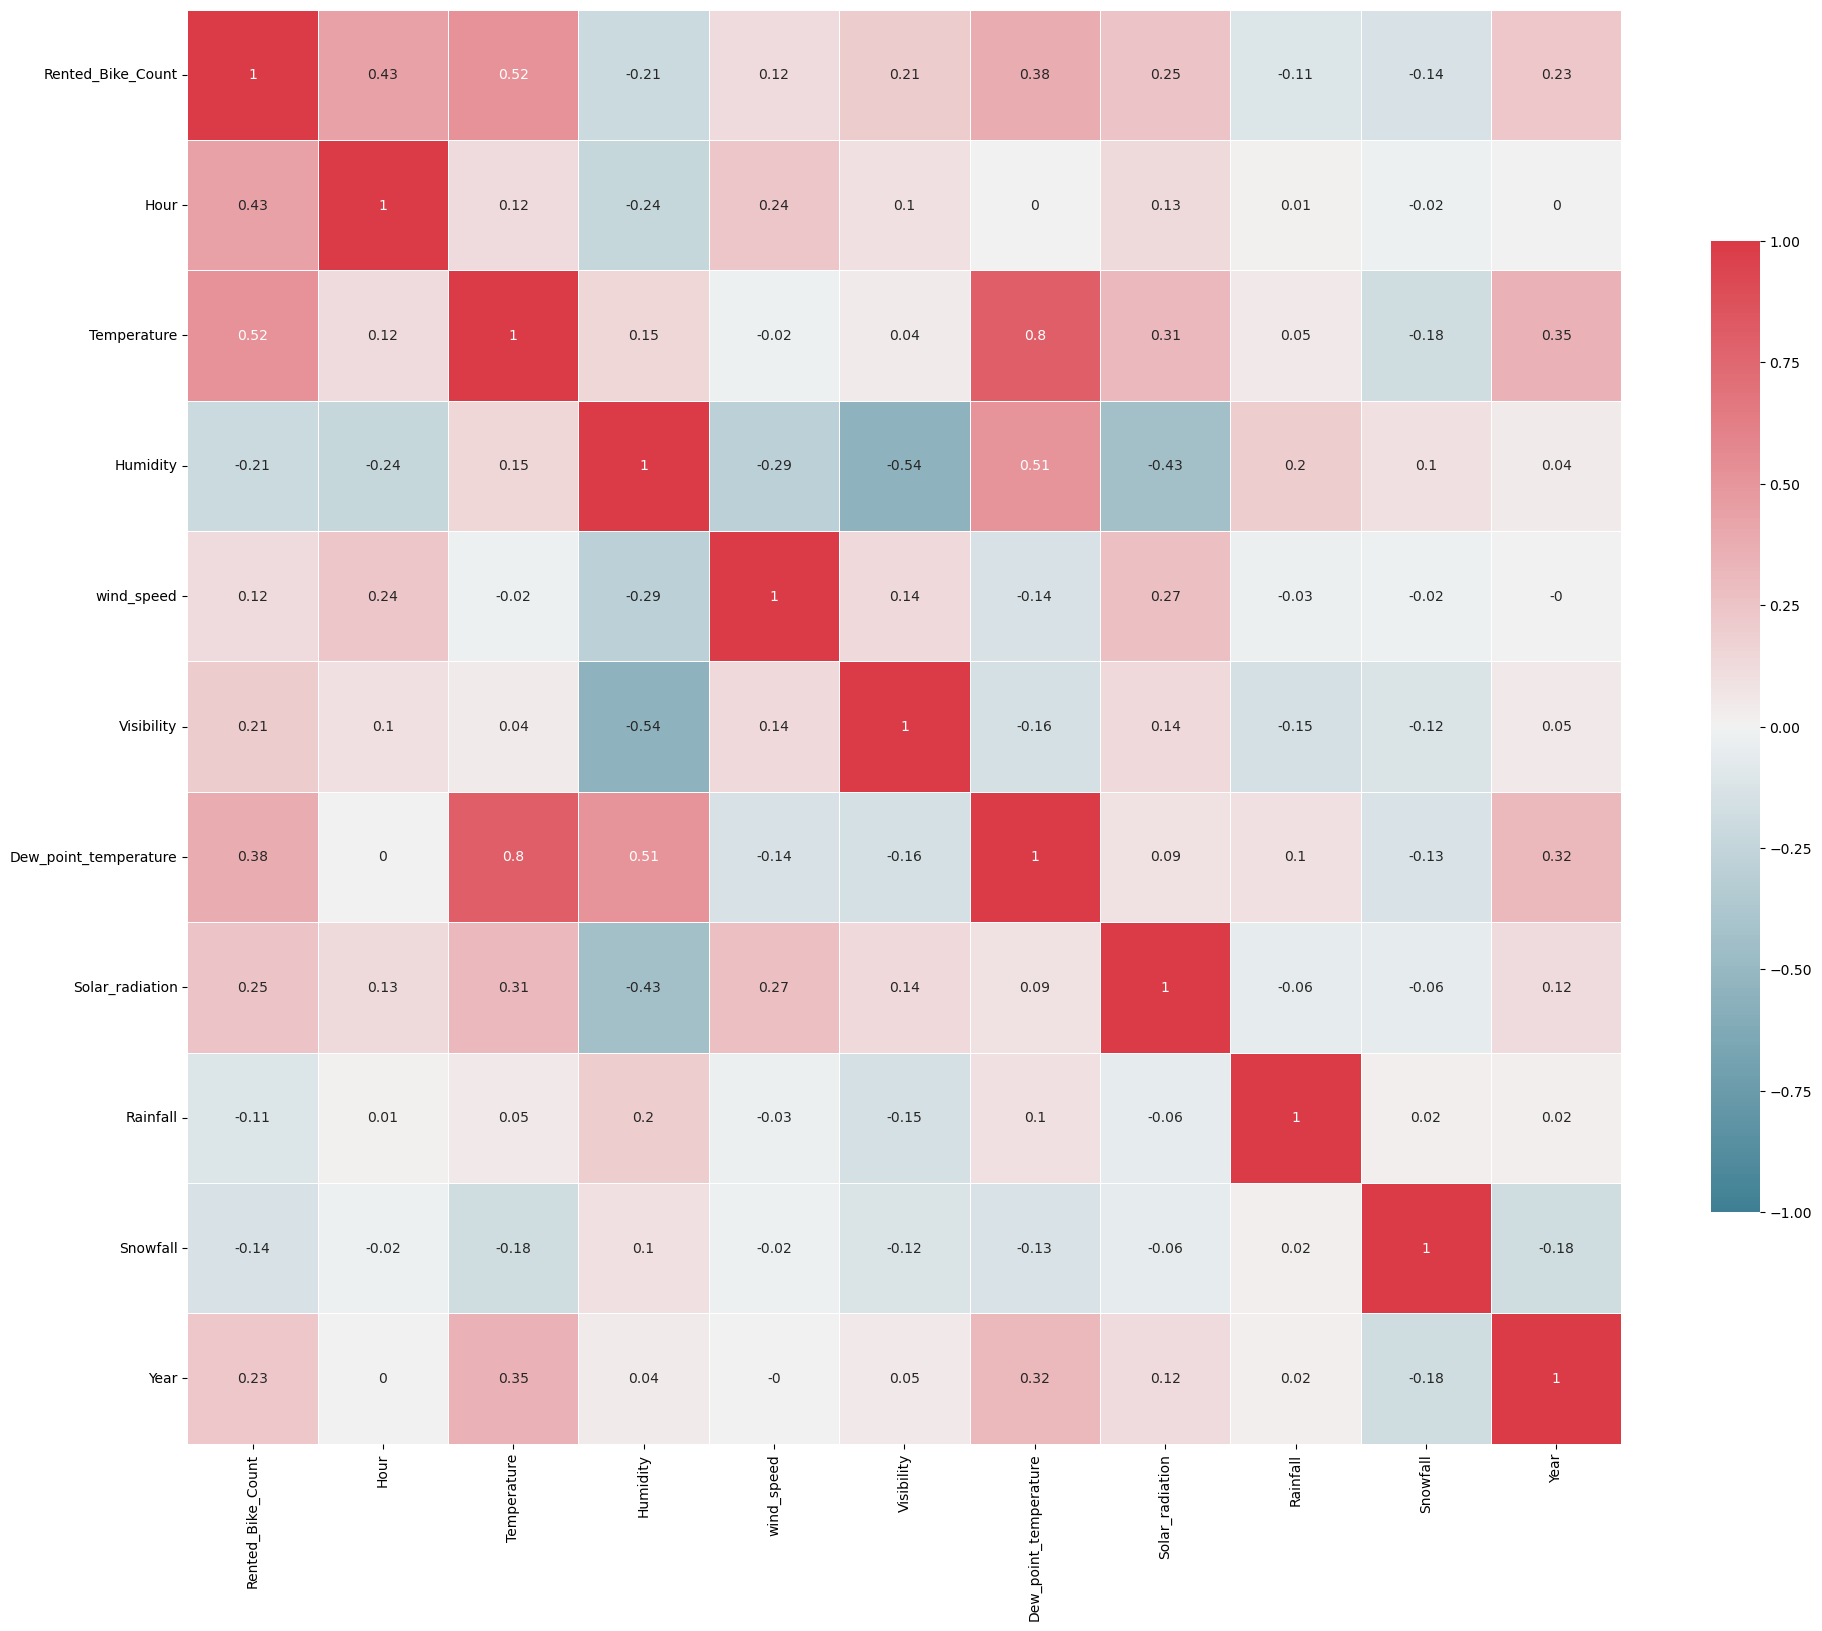

In [6]:
# Generando matriz de correlacion de datos
corr = bikedata.corr().round(2)
# Visualizando la matriz de correlacion
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

<function matplotlib.pyplot.show(close=None, block=None)>

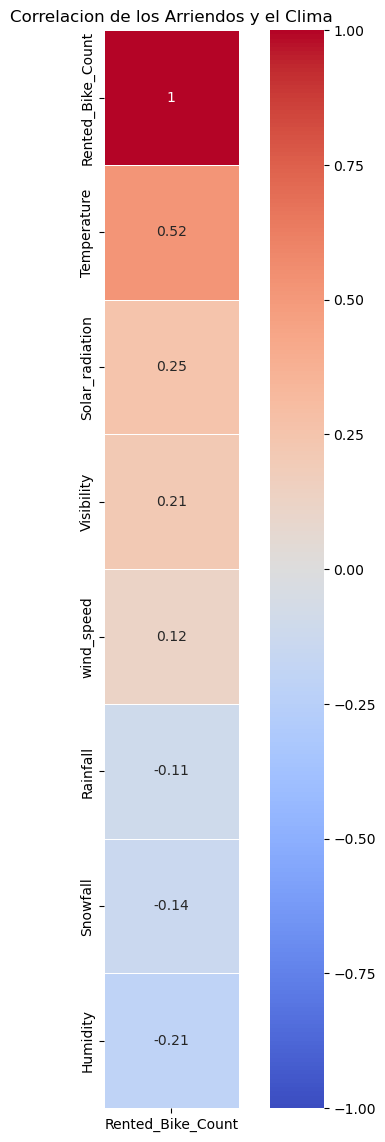

In [7]:
# Visualizando la correlacion de las variables del clima y el arriendo de Bicicletas

f, ax = plt.subplots(figsize=(8, 14))

corr= bikedata[['Temperature', 'wind_speed','Humidity','Solar_radiation','Rainfall','Visibility','Snowfall','Rented_Bike_Count']].corr()
sns.heatmap(data=corr[['Rented_Bike_Count']].sort_values(by= 'Rented_Bike_Count', ascending= False), vmin=-1, vmax=1, center=0,
            cmap='coolwarm', annot= True, square=True, linewidths = .5)
plt.title('Correlacion de los Arriendos y el Clima')
plt.savefig('Correlacion.png',dpi=300)
plt.show


### Eliminando las variables que no aportan al modelo

##### Se elimina la variable Functioning_Day, ya que todos los datos corresponden a 'Yes', por lo cual no es últil como predictor y la variable 'Dew_point_temperature'  que está correlacionada en un 0.91 a la variable Temperature.


In [8]:
bikedata_final= bikedata.drop(columns=['Functioning_Day','Dew_point_temperature' ], axis=1)
bikedata_final.head()

,Date,Rented_Bike_Count,Hour,Temperature,Humidity,wind_speed,Visibility,Solar_radiation,Rainfall,Snowfall,Seasons,Holiday,Month,Year,Weekday
0,2017-12-01,254.0,0,-52,37,22,2000,0,0,0,Winter,No Holiday,Dec,2017,Fryday
1,2017-12-01,204.0,1,-55,38,8,2000,0,0,0,Winter,No Holiday,Dec,2017,Fryday
2,2017-12-01,173.0,2,-6,39,1,2000,0,0,0,Winter,No Holiday,Dec,2017,Fryday
3,2017-12-01,107.0,3,-62,40,9,2000,0,0,0,Winter,No Holiday,Dec,2017,Fryday
4,2017-12-01,78.0,4,-6,36,23,2000,0,0,0,Winter,No Holiday,Dec,2017,Fryday


## Procesando Datos

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [10]:
bikedata_final.columns

Index(['Date', 'Rented_Bike_Count', 'Hour', 'Temperature', 'Humidity',
       'wind_speed', 'Visibility', 'Solar_radiation', 'Rainfall', 'Snowfall',
       'Seasons', 'Holiday', 'Month', 'Year', 'Weekday'],
      dtype='object')

In [11]:
mod1 = smf.ols(formula='Rented_Bike_Count ~ Hour + Temperature + Humidity + wind_speed + Visibility + Solar_radiation + Rainfall + Snowfall+ Seasons + Holiday + Month  + Year + Weekday',data=bikedata_final)
res1 = mod1.fit()
print(res1.summary())


                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     428.7
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:18:30   Log-Likelihood:                -65460.
No. Observations:                8760   AIC:                         1.310e+05
Df Residuals:                    8733   BIC:                         1.312e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.02

In [12]:
#Eliminando Variables con Pvalue mayor a 0.05 , se eliminina visibility

mod2 = smf.ols(formula='Rented_Bike_Count ~ Hour + Temperature + Humidity + wind_speed + Solar_radiation + Rainfall + Snowfall+ Seasons + Holiday + Month  + Year + Weekday',data=bikedata_final)
res2 = mod2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     445.8
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:23:23   Log-Likelihood:                -65461.
No. Observations:                8760   AIC:                         1.310e+05
Df Residuals:                    8734   BIC:                         1.312e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.02

Al emliminar la variable Visibility mejoran los indicadores

In [14]:
#Eliminando Variables con Pvalue mayor a 0.05
# Valiables : Month, Weekday, Visibility

mod3= smf.ols(formula='Rented_Bike_Count ~ Hour + Temperature + Humidity + wind_speed + Solar_radiation + Rainfall + Snowfall+ Seasons + Holiday + Year',data=bikedata_final)
res3 = mod3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     768.7
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:28:18   Log-Likelihood:                -65909.
No. Observations:                8760   AIC:                         1.318e+05
Df Residuals:                    8747   BIC:                         1.319e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.042e+

Al emilinar mes y día de la semana, empeoran los indicadores

In [15]:
#Eliminando Variables con Pvalue mayor a 0.05
# Valiables : Month, Weekday, Visibility, Snowfall   

mod4= smf.ols(formula='Rented_Bike_Count ~ Hour + Temperature + Humidity + wind_speed + Solar_radiation + Rainfall + Seasons + Holiday + Year',data=bikedata_final)
res4 = mod4.fit()
print(res4.summary())


                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     838.2
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:29:25   Log-Likelihood:                -65910.
No. Observations:                8760   AIC:                         1.318e+05
Df Residuals:                    8748   BIC:                         1.319e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.089e+

al eliminiar Snowfall no mejora el desempeño.

In [16]:
#Eliminando Variables con Pvalue mayor a 0.05
# Valiables : Month, Weekday,Year, Visibility, wind_speed

mod5= smf.ols(formula='Rented_Bike_Count ~ Hour + Temperature + Humidity + Solar_radiation + Rainfall + Snowfall+ Holiday',data=bikedata_final)
res5 = mod5.fit()
print(res5.summary())


                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     1045.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:30:35   Log-Likelihood:                -66403.
No. Observations:                8760   AIC:                         1.328e+05
Df Residuals:                    8752   BIC:                         1.329e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               329.44

Al eliminar nuevos parametros el desempeño empeora más.

## Evaluando los parametros

In [19]:
# Extraemos los parámetros del modelo para luego hacemos un gráfico de los datos y el ajuste

#El segundo fue el modelo con mejor desempeño.

params2 = res2.params 
print(params2)


Intercept                 -0.026177
Seasons[T.Spring]        -81.329951
Seasons[T.Summer]        119.443946
Seasons[T.Winter]       -383.031579
Holiday[T.No Holiday]    125.532004
Month[T.Aug]            -151.606661
Month[T.Dec]             -53.163902
Month[T.Feb]            -167.903677
Month[T.Jan]            -161.964001
Month[T.Jul]               0.408577
Month[T.Jun]             270.642031
Month[T.Mar]            -161.323573
Month[T.May]             256.874856
Month[T.Nov]             -54.925945
Month[T.Oct]             182.585348
Month[T.Sep]             217.232004
Weekday[T.Tuesday]        31.496110
Weekday[T.Wednesday]      45.964888
Weekday[T.Thursday]       15.449741
Weekday[T.Fryday]         41.159981
Weekday[T.Saturday]      -16.572149
Weekday[T.Sunday]        -81.101601
Hour                      31.798258
Temperature                1.158707
Humidity                  -8.594776
wind_speed                 1.714267
Solar_radiation           -0.511389
Rainfall                  -7

In [22]:
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt

## Evaluando los Modelos

#### Testeando la Linealidad

#### Harvey-Collier multiplier test for Null hypothesis 

#### that the linear specification is correct:

name = ["t value", "p value"]
test = sms.linear_harvey_collier(res2)
lzip(name, test)

Al intentar evaluar lienalidad del segundo modelo, que nos entrega los mejores valores aparece el mensaje:
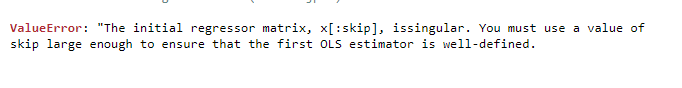


In [24]:
# Estimar normalidad de los residuos del segundo Modelo
# Jarque_Bera test
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(res2.resid)
lzip(name, test)


[('Jarque-Bera', 1868.9585702960173),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 0.837260141226303),
 ('Kurtosis', 4.521977747150731)]

In [25]:
# Omni test
name = ["Chi^2", "Two-tail probability"]
test = sms.omni_normtest(res2.resid)
lzip(name, test)

[('Chi^2', 1085.0169241197225),
 ('Two-tail probability', 2.4635906183894763e-236)]

#### Detección de Heteroscedasticidad:
    


In [26]:
# Breusch-Pagan test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(res2.resid, res2.model.exog)
lzip(name, test)


[('Lagrange multiplier statistic', 996.9103941598524),
 ('p-value', 3.890839581879941e-191),
 ('f-value', 44.863660344932235),
 ('f p-value', 5.667804427761535e-207)]

In [27]:
#Goldfeld-Quandttest
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(res2.resid, res2.model.exog)
lzip(name, test)

[('F statistic', 1.8840880037547483), ('p-value', 7.524566116066344e-96)]

In [28]:
# base code
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance 
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty. 
        Please test the code one your end before using.
    """

    def __init__(self, 
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]): 
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")     

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()
        
        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict, 
            y=self.residual, 
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, 
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i, 
                xy=(self.y_predict[i], self.residual[i]), 
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()
        
        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i, 
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]), 
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax
  
    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict, 
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, 
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i, 
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]), 
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage, 
            self.residual_norm, 
            alpha=0.5);
        
        sns.regplot(
            x=self.leverage, 
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i, 
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')
        
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the 
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))
        

    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams 
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

### Diagnostico Modelo 2

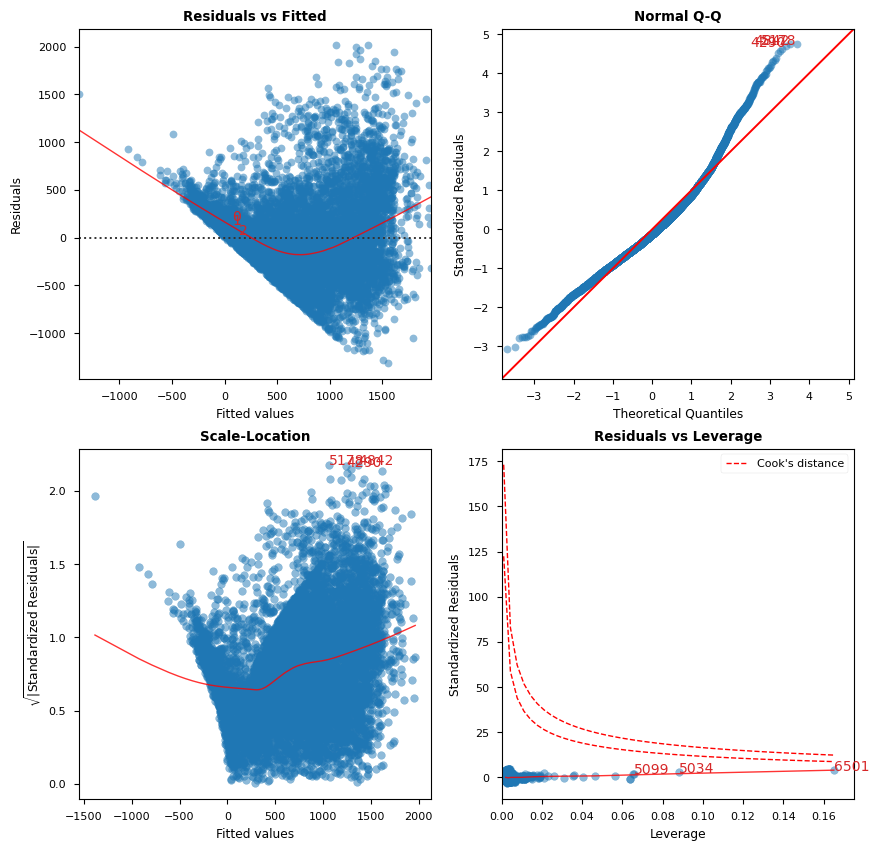

C:\Users\drasu\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\drasu\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                 Features  VIF Factor
0               Intercept        0.00
4   Holiday[T.No Holiday]        1.05
27               Rainfall        1.05
28               Snowfall        1.10
22                   Hour        1.16
25             wind_speed        1.20
26        Solar_radiation        1.57
24               Humidity        1.70
16     Weekday[T.Tuesday]        1.72
21      Weekday[T.Sunday]        1.72
17   Weekday[T.Wednesday]        1.72
18    Weekday[T.Thursday]        1.72
20    Weekday[T.Saturday]        1.73
19      Weekday[T.Fryday]        1.73
11           Month[T.Mar]        1.91
12           Month[T.May]        1.94
23            Temperature        3.98
14           Month[T.Oct]         inf
13           Month[T.Nov]         inf
10           Month[T.Jun]         inf
9            Month[T.Jul]         inf
8            Month[T.Jan]         inf
7            Month[T.Feb]         inf
6            Month[T.Dec]         inf
5            Month[T.Aug]         inf
3       Seas

In [29]:

# Fig and ax can be used to modify axes or plot properties after the fact.
cls = Linear_Reg_Diagnostic(res2)
fig, ax = cls()

#fig.savefig('../../docs/source/_static/images/linear_regression_diagnostics_plots.png')

## Revisando Variables

In [30]:
# Usando solo la variable temperatura

mod_temperatura = smf.ols(formula='Rented_Bike_Count ~  Temperature' ,data=bikedata_final)
res_temperatura = mod_temperatura.fit()
print(res_temperatura.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     3175.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        20:52:49   Log-Likelihood:                -67708.
No. Observations:                8760   AIC:                         1.354e+05
Df Residuals:                    8758   BIC:                         1.354e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     409.3954      8.266     49.525      

In [31]:
# Extraemos los parámetros del modelo para luego hacemos un gráfico de los datos y el ajuste

params_temperatura= res_temperatura.params 
print(params_temperatura)

Intercept      409.395381
Temperature      2.786727
dtype: float64


Text(0.5, 1.0, 'Regresión de Arriendos en función de Temperatura')

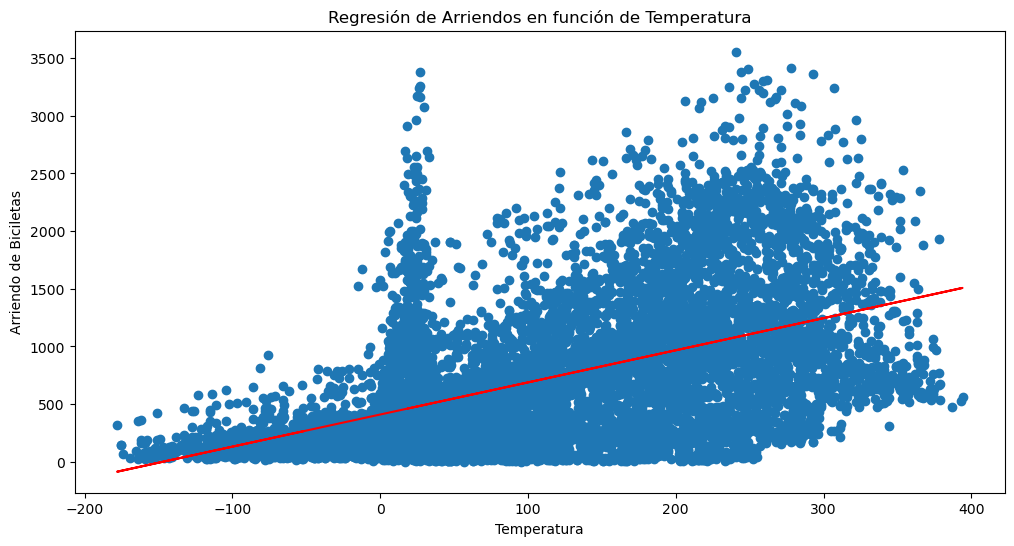

In [32]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(bikedata_final['Temperature'], bikedata_final['Rented_Bike_Count'], "o", label="Data")
ax.plot(bikedata_final['Temperature'], params_temperatura['Intercept']+params_temperatura['Temperature']*bikedata_final['Temperature']  , "r-", label="Predicted")
ax.set_ylabel("Arriendo de Biciletas")
ax.set_xlabel("Temperatura")
ax.set_title("Regresión de Arriendos en función de Temperatura")


### Chequeo del modelo

In [33]:
name = ["t value", "p value"]
test = sms.linear_harvey_collier(res_temperatura)
lzip(name, test)


[('t value', 7.7876054959367105), ('p value', 7.607627768700598e-15)]

In [34]:
# Estimar normalidad de los residuos:
# Jarque_Bera test
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(res_temperatura.resid)
lzip(name, test)

[('Jarque-Bera', 2239.5929901965546),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 0.9809262118362768),
 ('Kurtosis', 4.51228511655312)]

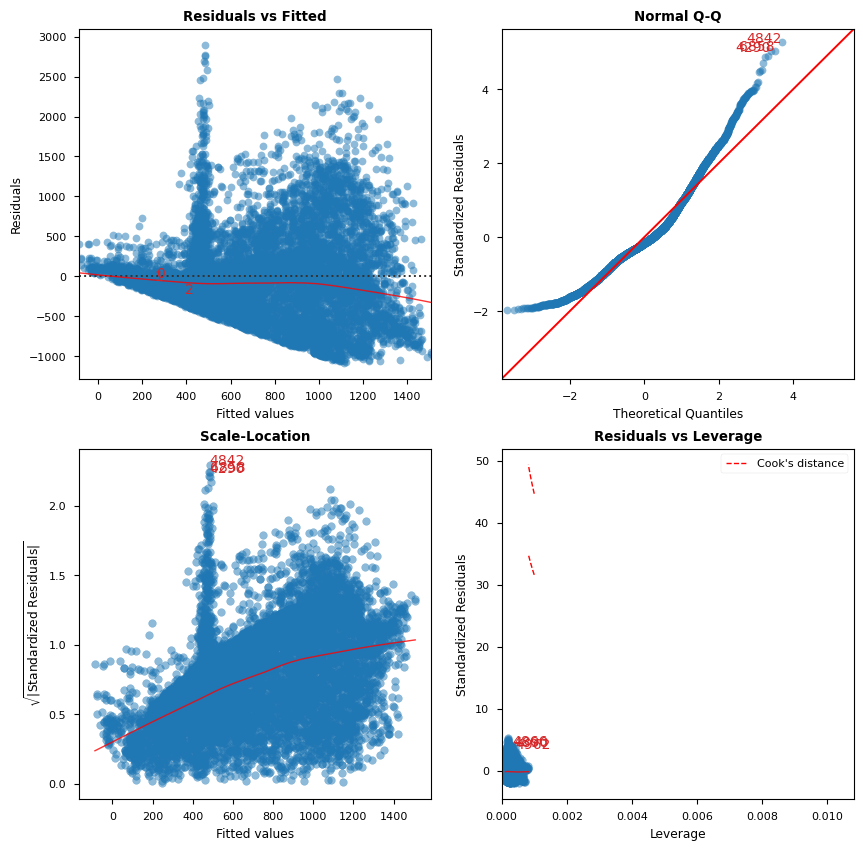

      Features  VIF Factor
1  Temperature        1.00
0    Intercept        1.98


In [35]:
cls_temperatura = Linear_Reg_Diagnostic(res_temperatura)
fig, ax = cls_temperatura()

### LLUVIA

In [36]:
# Usando solo la variable Lluvia

mod_lluvia = smf.ols(formula='Rented_Bike_Count ~  Rainfall' ,data=bikedata_final)
res_lluvia = mod_lluvia.fit()
print(res_lluvia.summary())


                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     102.3
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           6.54e-24
Time:                        20:55:10   Log-Likelihood:                -69012.
No. Observations:                8760   AIC:                         1.380e+05
Df Residuals:                    8758   BIC:                         1.380e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    744.5912      6.866    108.441      0.0

In [37]:
# Extraemos los parámetros del modelo para luego hacemos un gráfico de los datos y el ajuste

params_lluvia= res_lluvia.params 
print(params_lluvia)

Intercept    744.591187
Rainfall      -8.779804
dtype: float64


Text(0.5, 1.0, 'Regresión de Arriendos en función de la Precipitación (mm)')

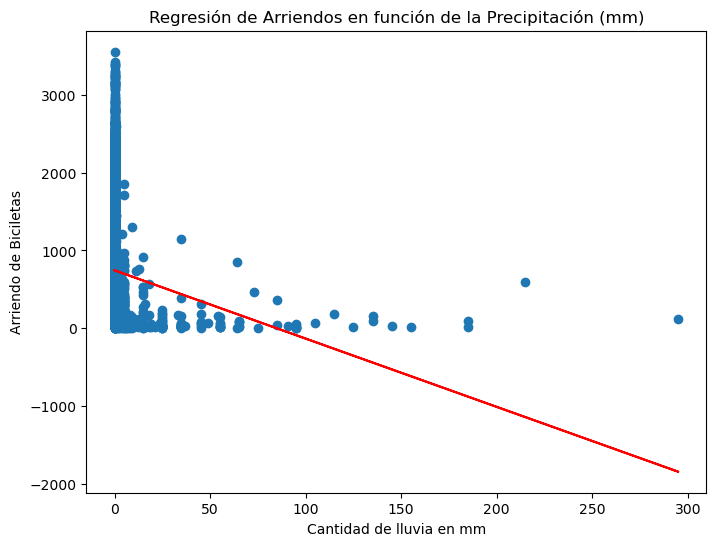

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(bikedata_final['Rainfall'], bikedata_final['Rented_Bike_Count'], "o", label="Data")
ax.plot(bikedata_final['Rainfall'], params_lluvia['Intercept']+params_lluvia['Rainfall']*bikedata_final['Rainfall']  , "r-", label="Predicted")
ax.set_ylabel("Arriendo de Biciletas")
ax.set_xlabel("Cantidad de lluvia en mm")
ax.set_title("Regresión de Arriendos en función de la Precipitación (mm)")


### Chequeo del modelo

#Testeando la Linealidad

#Harvey-Collier multiplier test for Null hypothesis

#that the linear specification is correct:

Retorna Error:

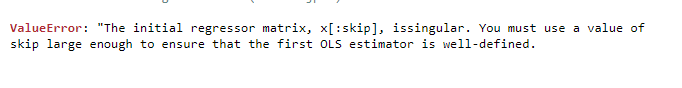

In [40]:
# Estimar normalidad de los residuos:
# Jarque_Bera test
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(res_lluvia.resid)
lzip(name, test)


[('Jarque-Bera', 2084.503614749205),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 1.1271840952942627),
 ('Kurtosis', 3.7929646075296723)]

C:\Users\drasu\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


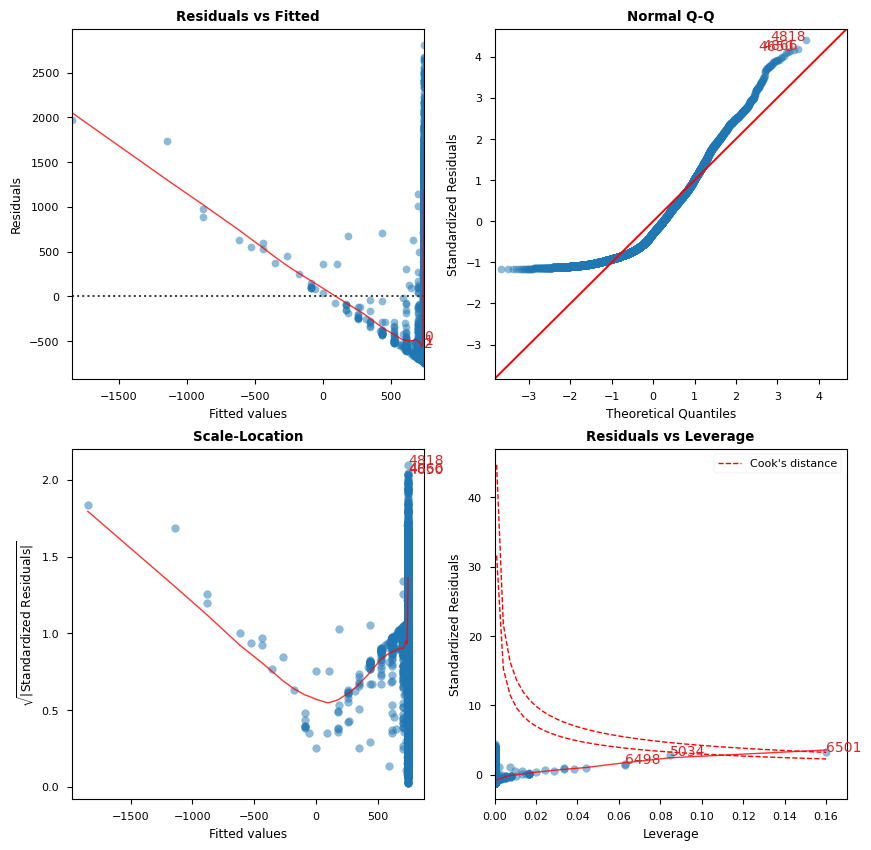

    Features  VIF Factor
1   Rainfall        1.00
0  Intercept        1.01


In [41]:
cls_lluvia = Linear_Reg_Diagnostic(res_lluvia)
fig, ax = cls_lluvia()

### NIEVE

In [45]:
# Usando solo la variable Nieve

mod_nieve = smf.ols(formula='Rented_Bike_Count ~  Snowfall' ,data=bikedata_final)
res_nieve = mod_nieve.fit()
print(res_nieve.summary())


                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     169.8
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           1.82e-38
Time:                        21:01:54   Log-Likelihood:                -68979.
No. Observations:                8760   AIC:                         1.380e+05
Df Residuals:                    8758   BIC:                         1.380e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    750.7219      6.881    109.109      0.0

In [43]:
# Extraemos los parámetros del modelo para luego hacemos un gráfico de los datos y el ajuste

params_nieve= res_nieve.params 
print(params_nieve)

Intercept    750.721931
Snowfall     -22.817821
dtype: float64


Text(0.5, 1.0, 'Regresión de Arriendos en función de Caida de Nieve (cm)')

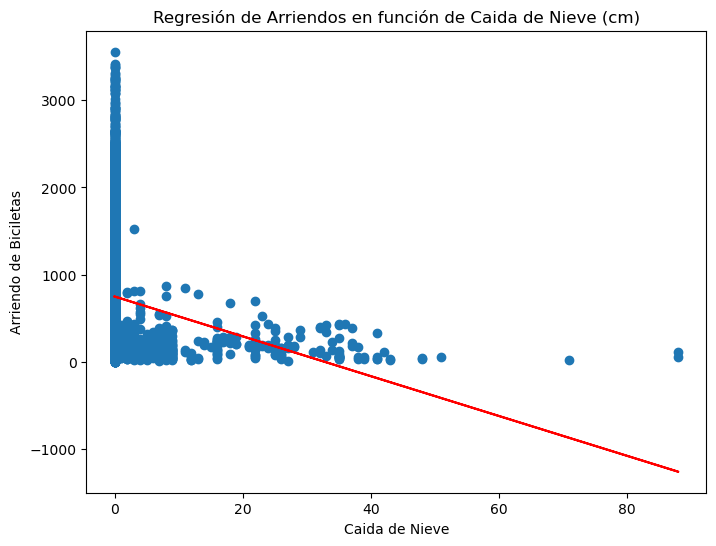

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(bikedata_final['Snowfall'], bikedata_final['Rented_Bike_Count'], "o", label="Data")
ax.plot(bikedata_final['Snowfall'], params_nieve['Intercept']+params_nieve['Snowfall']*bikedata_final['Snowfall']  , "r-", label="Predicted")
ax.set_ylabel("Arriendo de Biciletas")
ax.set_xlabel("Caida de Nieve")
ax.set_title("Regresión de Arriendos en función de Caida de Nieve (cm)")


### Chequeo del modelo

#Testeando la Linealidad

#Harvey-Collier multiplier test for Null hypothesis

#that the linear specification is correct:

Retorna Error:

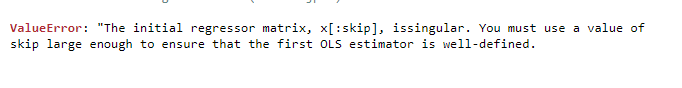

In [48]:
#Estimar normalidad de los residuos:

# Jarque_Bera test

name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(res_nieve.resid)
lzip(name, test)


[('Jarque-Bera', 2032.8650494513397),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 1.1114393877526856),
 ('Kurtosis', 3.792655811544832)]

C:\Users\drasu\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


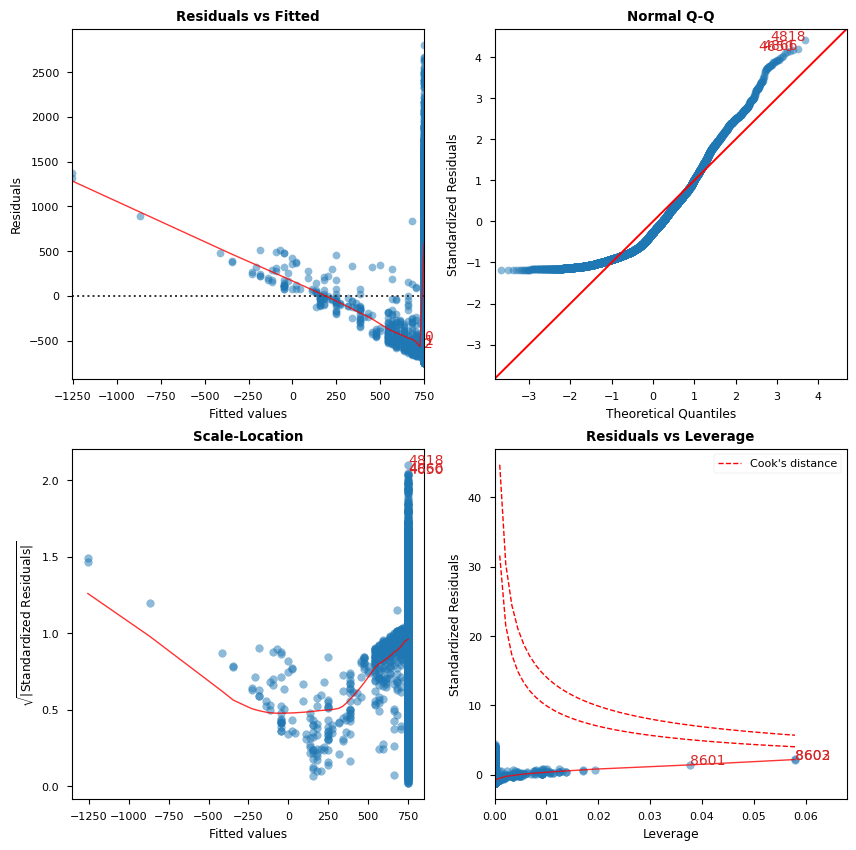

    Features  VIF Factor
1   Snowfall        1.00
0  Intercept        1.02


In [49]:
cls_nieve = Linear_Reg_Diagnostic(res_nieve)
fig, ax = cls_nieve()

### HORAS DEL DÍA

In [50]:
# Usando solo la variable Hora

mod_hora = smf.ols(formula='Rented_Bike_Count ~  Hour' ,data=bikedata_final)
res_hora = mod_hora.fit()
print(res_hora.summary())


                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     1990.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:06:43   Log-Likelihood:                -68166.
No. Observations:                8760   AIC:                         1.363e+05
Df Residuals:                    8758   BIC:                         1.364e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    277.7272     12.013     23.120      0.0

In [51]:
# Extraemos los parámetros del modelo para luego hacemos un gráfico de los datos y el ajuste

params_hora= res_hora.params 
print(params_hora)

Intercept    277.727219
Hour          39.919774
dtype: float64


Text(0.5, 1.0, 'Regresión de Arriendos en función de las Horas del Día')

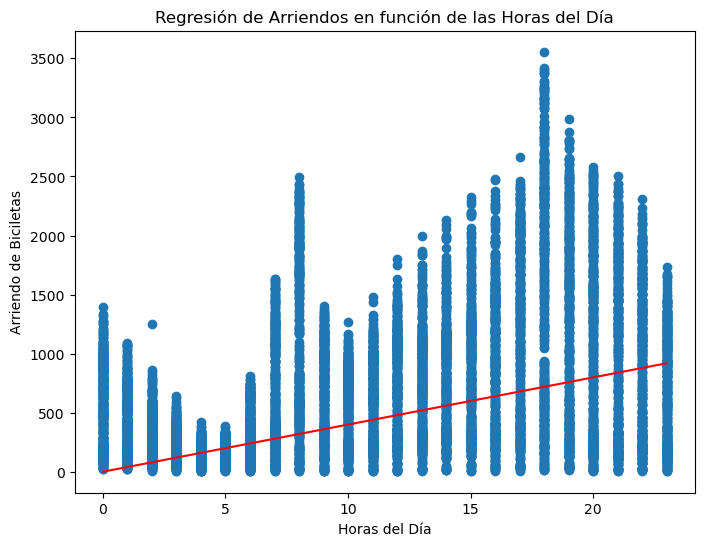

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(bikedata_final['Hour'], bikedata_final['Rented_Bike_Count'], "o", label="Data")
ax.plot(bikedata_final['Hour'], params2['Intercept']+params_hora['Hour']*bikedata_final['Hour']  , "r-", label="Predicted")
ax.set_ylabel("Arriendo de Biciletas")
ax.set_xlabel("Horas del Día")
ax.set_title("Regresión de Arriendos en función de las Horas del Día")


### Chequeo del modelo

In [53]:
#Linealidad

name = ["t value", "p value"]
test = sms.linear_harvey_collier(res_hora)
lzip(name,  test)



[('t value', 45.279140320730654), ('p value', 0.0)]

In [54]:
# Estimar normalidad de los residuos:
# Jarque_Bera test
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(res_hora.resid)
lzip(name, test)


[('Jarque-Bera', 1069.8180872540563),
 ('Chi^2 two-tail prob.', 4.919874591193361e-233),
 ('Skew', 0.7688934954892616),
 ('Kurtosis', 3.7524756664554086)]

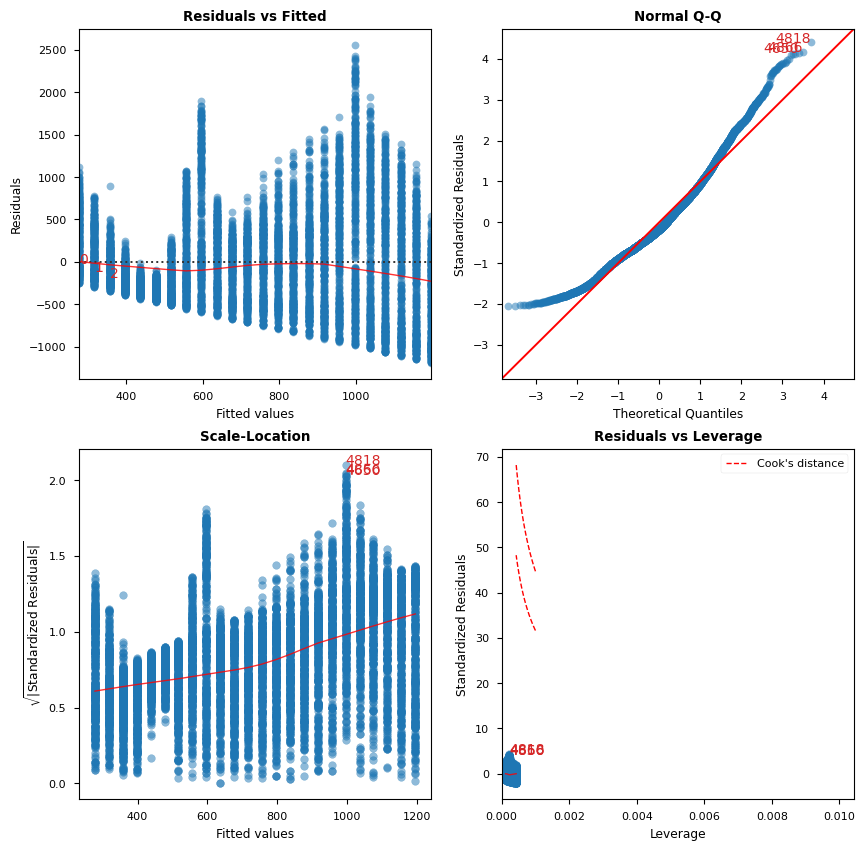

    Features  VIF Factor
1       Hour        1.00
0  Intercept        3.76


In [55]:
cls_hora = Linear_Reg_Diagnostic(res_hora)
fig, ax = cls_hora()

### ESTACION DEL AÑO

In [56]:
#bikedata = bikedata_final['Seasons'] = bike
bikedata_final['cat_seasons'] =bikedata_final['Seasons'].map({'Spring': 1, 'Summer': 0, 'Winter':3, 'Autumn':4})

In [57]:
bikedata_final['cat_seasons'].value_counts()

1    2208
0    2208
4    2184
3    2160
Name: cat_seasons, dtype: int64

In [58]:
# Usando solo la variable Hora

mod_estacion = smf.ols(formula='Rented_Bike_Count ~  cat_seasons' ,data=bikedata_final)
res_estacion = mod_estacion.fit()
print(res_estacion.summary())


                            OLS Regression Results                            
Dep. Variable:      Rented_Bike_Count   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     299.4
Date:                Mon, 17 Oct 2022   Prob (F-statistic):           5.40e-66
Time:                        21:11:06   Log-Likelihood:                -68916.
No. Observations:                8760   AIC:                         1.378e+05
Df Residuals:                    8758   BIC:                         1.378e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     883.5901     10.839     81.517      

In [59]:
# Extraemos los parámetros del modelo para luego hacemos un gráfico de los datos y el ajuste

params_estacion= res_estacion.params 
params_estacion=params_estacion.astype(int)

In [60]:
params_estacion

Intercept      883
cat_seasons    -73
dtype: int32

Text(0.5, 1.0, 'Regresión de Arriendos en función de las Estaciones')

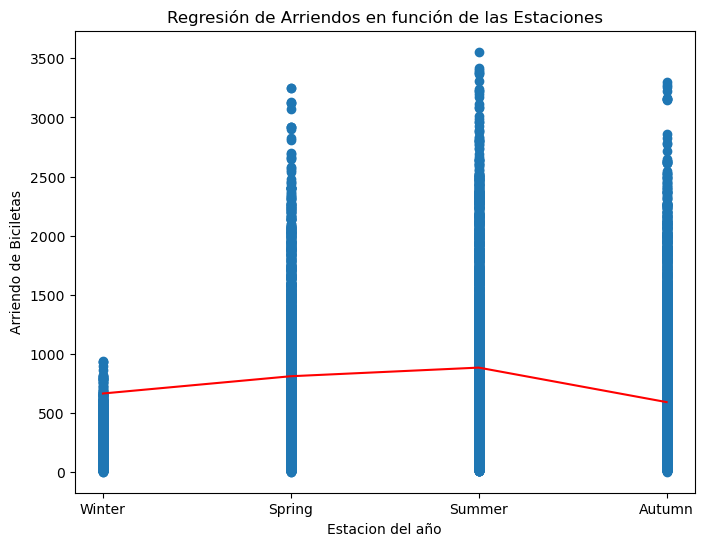

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(bikedata_final['Seasons'], bikedata_final['Rented_Bike_Count'], "o", label="Data")
ax.plot(bikedata_final['Seasons'], params_estacion['Intercept']+params_estacion['cat_seasons']*bikedata_final['cat_seasons']  , "r-", label="Predicted")
ax.set_ylabel("Arriendo de Biciletas")
ax.set_xlabel("Estacion del año")
ax.set_title("Regresión de Arriendos en función de las Estaciones")


### Chequeo del modelo

#Testeando la Linealidad

#Harvey-Collier multiplier test for Null hypothesis

#that the linear specification is correct:

Retorna Error:

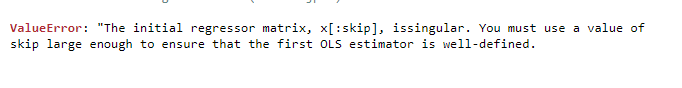

In [65]:
# Estimar normalidad de los residuos:
# Jarque_Bera test
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(res_estacion.resid)
lzip(name, test)


[('Jarque-Bera', 2023.0339043819615),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 1.1106287675583446),
 ('Kurtosis', 3.780111277209662)]

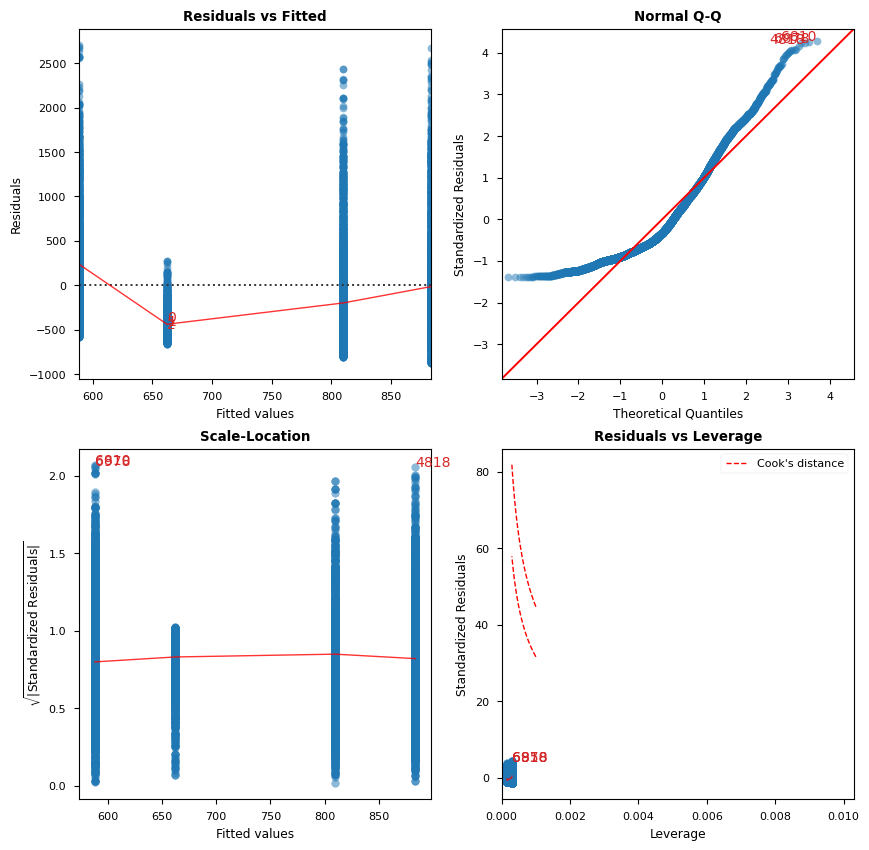

      Features  VIF Factor
1  cat_seasons        1.00
0    Intercept        2.58


In [67]:
cls_estacion = Linear_Reg_Diagnostic(res_estacion)
fig, ax = cls_estacion()